In [5]:
# Load dependencies
%matplotlib inline
import matplotlib
import json
import time
import requests
import os.path
import pandas as pd
import numpy as np
from sklearn import decomposition
from scipy.stats import zscore
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Image

marrow (30854, 53)
(14107, 6) ... after filtering
spleen (30853, 53)
(14273, 6) ... after filtering


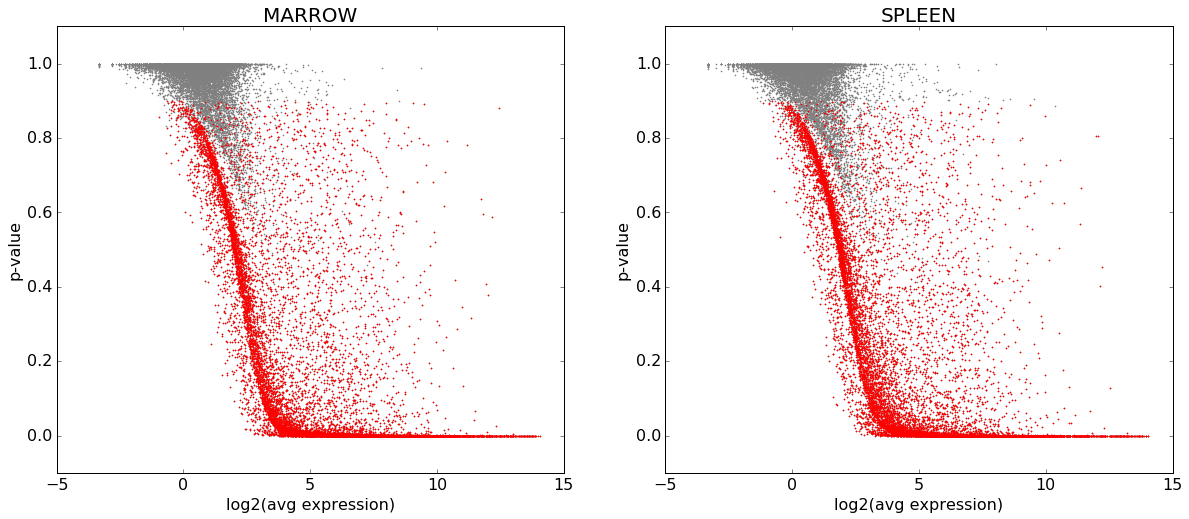

In [26]:
p_cut = 0.90 # require gt p probability of background difference
s_cut = 0.0 # require minimum of each row is greeater than s

# Load data
dat = {}
dat['marrow'] = pd.read_table('GATA1_marrow_profile.txt',sep='\t',index_col=0)
dat['spleen'] = pd.read_table('GATA1_spleen_profile.txt',sep='\t',index_col=0)

fig = plt.figure(figsize=(20, 8), dpi=100)

for i in range(len(dat.keys())):
    tissue = dat.keys()[i]
    df = dat[tissue]
    
    print tissue, df.shape
    
    pvals = df[['cd1.Detection Pval','cd2.Detection Pval','cd3.Detection Pval',
                'gat1.Detection Pval','gat2.Detection Pval','gat3.Detection Pval']]
    signal = df[['cd1.AVG_Signal','cd2.AVG_Signal','cd3.AVG_Signal',
                 'gat1.AVG_Signal','gat2.AVG_Signal','gat3.AVG_Signal']]
    
    signal.columns = [ x.replace('.AVG_Signal','.'+tissue) for x in signal.columns.values ]
    
    multi_p = 1.0 - pvals.apply( lambda p: np.prod(1.0-p), axis=1)

    fig.add_subplot(1,2,i+1)

    x = np.mean(np.log2(signal),axis=1)
    y = multi_p
    keep = (np.min(signal,axis=1) > s_cut) & (y <= p_cut)
    plt.axis([-5, 15, -0.1, 1.1])
    plt.scatter(x,y,s=1,c='gray',marker='x')
    plt.scatter(x[keep],y[keep],s=1,c='red',marker='x')
    plt.xlabel('log2(avg expression)',fontsize=16)
    plt.ylabel('p-value',fontsize=16)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.title(tissue.upper(),fontsize=20)

    dat[tissue] = signal[keep]
    print dat[tissue].shape,'... after filtering'


3502 null genes removed


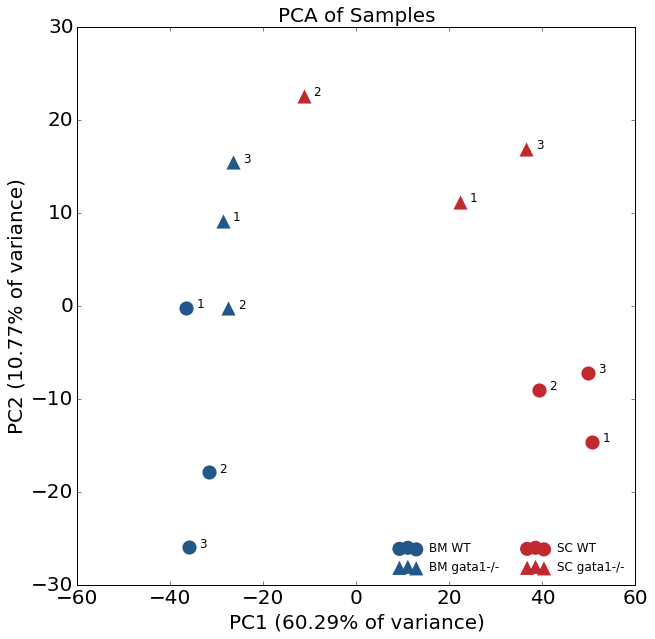

In [27]:
df = pd.concat(dat.values(),axis=1)

print len(df[df.isnull().any(axis=1)]) ,"null genes removed"
df = df[~df.isnull().any(axis=1)]

samples = df.columns.values
colors = np.array([ '#C1292E' if 'spleen' in x else '#235789' for x in samples ])
shapes = np.array([ u'o' if 'cd' in x else u'^' for x in samples ])
labels = np.array([ x.split('.')[0][-1] for x in samples ])

# Choose 2000 genes with greatest variance and zscore them
mat = np.log2(df.transpose().as_matrix() + 1.0)
featvars = list(np.var(mat,axis=0))
select = np.argsort(featvars)[-2000:]
mat = zscore(mat[:,select])

# Compute PCA Coordinates and Variance
pca = decomposition.PCA(n_components=None)
pca.fit(mat)
variance_explained = pca.explained_variance_ratio_[0:2] * 100

pca_coords = pca.transform(mat)[:, 0:2]
pca1, pca2 = zip(*pca_coords)

# Plot Results
fig = plt.figure(figsize=(10, 10), dpi=80)

legs = []
for i in range(0,12,3):
    _s, _c  = shapes[i], colors[i]
    _x, _y = np.array(pca1)[range(i,i+3)], np.array(pca2)[range(i,i+3)]
    ax = plt.scatter(_x, _y, s=200, marker=_s, c=_c, lw = 0)
    legs.append(ax)

axlabels = ['PC%s (%.2f' % (i,pct) + '%' + ' of variance)'
          for i,pct in enumerate(variance_explained, start=1)]

for label, x, y in zip(labels,pca1,pca2):
    plt.annotate(label,xy=(x,y),xytext = (10, 0), textcoords = 'offset points', fontsize=12)
    
plt.xlabel(axlabels[0],fontsize=20)
plt.ylabel(axlabels[1],fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("PCA of Samples",fontsize=20)

plt.legend(legs,('BM WT','BM gata1-/-','SC WT','SC gata1-/-'),
           ncol=2, loc='lower right',frameon=False)
plt.show()

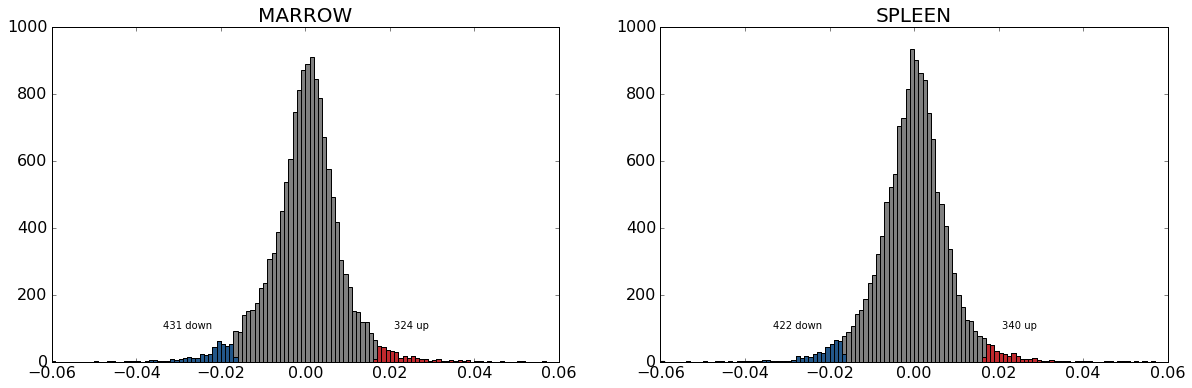

In [58]:
from chdir import chdir

cdsigs = {}
degs = {}

fig = plt.figure(figsize=(20, 6), dpi=100)

for i in range(len(dat.keys())):
    tissue = dat.keys()[i]
    degs[tissue] = {}
    df = dat[tissue]
    df = np.log2(df + 1.0)
    genelist = df.index.values
    
    ctrData = df[[ x+'.'+tissue for x in ['cd1','cd2','cd3']]].values
    expData = df[[ x+'.'+tissue for x in ['gat1','gat2','gat3']]].values

    # Get the charactersitic direction signature
    [cdGenes,cdVector] = chdir(ctrData,expData,genelist)

    s = pd.Series(cdVector, index=cdGenes, name=tissue).sort_index().dropna()
    s = s[[ gene for gene in genelist if '$' not in gene ]]
    cdsigs[tissue] = s
    dg = s[np.abs(s) > 2*np.std(s)].sort_values(ascending=False)
    degs[tissue]['dn'] = dg[dg<0.0]
    degs[tissue]['up'] = dg[dg>0.0]
    s.to_csv('GATA1_'+tissue+'_cdVector.txt',sep='\t')
    degs[tissue]['dn'].to_csv('GATA1_'+tissue+'_deg_dn.txt',sep='\t')
    degs[tissue]['up'].to_csv('GATA1_'+tissue+'_deg_up.txt',sep='\t')
    
    fig.add_subplot(1,2,i+1)
    plt.hist(s,np.arange(-0.06,0.06,0.001),facecolor='gray')
    plt.hist(dg[dg>0.0],np.arange(-0.06,0.06,0.001),facecolor='#C1292E')
    plt.hist(dg[dg<0.0],np.arange(-0.06,0.06,0.001),facecolor='#235789')
    plt.annotate(str(len(dg[dg<0.0]))+' down',xy=(-4*np.std(s),100))#,textcoords = 'offset points', fontsize=12)
    plt.annotate(str(len(dg[dg>0.0]))+' up',xy=(2.5*np.std(s),100))
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.title(tissue.upper(),fontsize=20)
    plt.axis([-0.06,0.06,0,1000])


In [10]:
common_genes = np.unique(cdsigs['spleen'].index.tolist() + cdsigs['marrow'].index.tolist())

cd_diff = cdsigs['spleen'][common_genes] - cdsigs['marrow'][common_genes]
cd_diff = cd_diff.dropna()
cd_diff = cd_diff/np.linalg.norm(cd_diff)

cd_diff.to_csv('GATA1_SC-BM_cdVector.txt',sep='\t')
deg_diff = cd_diff[np.abs(cd_diff) > 2*np.std(cd_diff)]

deg_diff[deg_diff>0.0].to_csv('GATA1_SC-BM_degs_up-spleen.txt',sep='\t')
deg_diff[deg_diff<0.0].to_csv('GATA1_SC-BM_degs_dn-marrow.txt',sep='\t')
deg_diff.to_csv('GATA1_SC-BM_degs.txt',sep='\t')

In [61]:
# Libraries to use:
libraries = ['MGI_Mammalian_Phenotype_Level_4','WikiPathways_2015',
             'ChEA_2015','PPI_Hub_Proteins','ENCODE_TF_ChIP-seq_2015',
            'KEGG_2016']

# Use this function to call the Enrichr API:
ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
def fetch_enrichr_results(genes, description=''):
    """Returns a dict which maps Enrichr libraries to enrichment results."""
    session = requests.session()
    payload = {'list': (None, genes), 'description': (None, description)}
    session.post(ENRICHR_URL, files=payload)
    results = {}
    for library in libraries:
        get_url = ENRICHR_URL + '?backgroundType=%s' % library
        response = session.get(get_url)
#         print [str(x) for x in json.loads(response.text).keys()]
        if response.ok:
            results[library] = json.loads(response.text)[library]
        else: print "Error"
    return results

def enrichr2dataframe(results, library, score):
    print "Aggregating",library,"vectors"
    termsUp = {}
    termsDn = {}

    table = results[library]
    
    for i in range(len(table)):
        [rank, name, pval, zscore, cs, genes, adjpval, _ap, _p] = table[i]
        
    value = {'cs':cs, 'p-value':pval, 'z-score':zscore}
    
    for i in range(ncond):
        
        up = open('DToxS_'+conditions[i]+'_'+library+'_up.csv')
        dn = open('DToxS_'+conditions[i]+'_'+library+'_down.csv')
        
#         sigUp = genfromtxt(open('DToxS_'+conditions[i]+'_'+library+'_up.csv'),
#                            delimiter=',',dtype='string',usecols=(-1,)
#         sigDn = genfromtxt(open('DToxS_'+conditions[i]+'_'+library+'_down.csv'),
#                            delimiter=',',dtype='string')
                           
        for j in range(len(sigUp)): # Up
            term = sigUp[j][0]
            value = sigUp[j][-1]
            if term not in termsUp: termsUp[term] = np.zeros(ncond)
            termsUp[term][i] = value

        for j in range(len(sigDn)): # Down
            term = sigDn[j][0]
            value = sigDn[j][3]
            if term not in termsDn: termsDn[term] = np.zeros(ncond)
            termsDn[term][i] = value

    return termsUp, termsDown

In [59]:
enriched = {}
for tissue in dat.keys():
    enriched[tissue] = {}
#     upOutput = fetch_enrichr_results('\n'.join(degs[tissue]['up'].index),tissue+' GATA1-/-')
#     dnOutput = fetch_enrichr_results('\n'.join(degs[tissue]['dn'].index),tissue+' GATA1-/-')
    enriched[tissue]['up'] = fetch_enrichr_results('\n'.join(degs[tissue]['up'].index),tissue+' GATA1-/-')
    enriched[tissue]['dn'] = fetch_enrichr_results('\n'.join(degs[tissue]['dn'].index),tissue+' GATA1-/-')

In [62]:
print enriched['spleen']['up']['ENCODE_TF_ChIP-seq_2015'][:5]

[[1, u'JUND_T47D_hg19', 0.6213443078222962, -1.9713535747546416, 2.2293990222102748e-10, [u'SPINT1', u'ANKRD22'], 0.9999999998869102, 0.19091289103218564, 0.0020564465380014303], [2, u'MAFK_GM12878_hg19', 0.23529409676212495, -1.957202922900379, 2.2133960840202254e-10, [u'IL15', u'RNPEP', u'SNX24', u'IGF1', u'NUDT6'], 0.9999999998869102, 0.009271612494794614, 0.0020564465380014303], [3, u'CBX3_HCT116_hg19', 0.6927180097249673, -1.9445868114401592, 2.199128553875609e-10, [u'ANKRD22', u'ID1', u'SLC37A4'], 0.9999999998869102, 0.15517767083214393, 0.0020564465380014303], [4, u'STAT5A_K562_hg19', 0.30978553091729044, -1.923701765341245, 2.1755097054112834e-10, [u'EGFL7', u'LRG1', u'ID1', u'GP6', u'ITM2A'], 0.9999999998869102, 0.014339252780828619, 0.0020564465380014303], [5, u'NANOG_H1-hESC_hg19', 0.8567277416132029, -1.921623058325987, 2.1731589006410867e-10, [u'ID1'], 0.9999999998869102, 0.5199200998124027, 0.007082649000264464]]


In [6]:
# import the widget
from clustergrammer_widget import *
from copy import deepcopy

df = pd.DataFrame(np.random.rand(10,10),
                  index=[ str(x) for x in range(10)]
                  ,columns=[ str(x) for x in range(10)])
net = deepcopy(Network())
tmp = {}
tmp["mat"] = df
net.df_to_dat(tmp)
# net.load_file('rc_two_cats.txt')
net.make_clust()

clustergrammer_notebook(network = net.export_net_json())

In [7]:
import ipywidgets
print ipywidgets.__version__

6.0.0.beta6
